In [1]:
import pyvinecopulib as pv
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF as fit_ecdf
import seaborn as sns
from tqdm import tqdm

# Utilising other DRE losses for better tail modelling

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Ratio(nn.Module):
    """
    Simple MLP classifier for the ratio p/q.

    Args:
        h_dim (int): hidden dimension
        in_dim (int): input dimension
        h_layers (int): number of hidden layers
    """
    def __init__(self, h_dim=100, in_dim=2, h_layers=2, normalising_cst = False, c = 1.0):
        super(Ratio, self).__init__()

        self.h_dim = h_dim
        self.in_dim = in_dim
        self.h_layers = h_layers
        self.normalising_cst = normalising_cst
        if self.normalising_cst:
            self.c = nn.Parameter(torch.tensor(c))

        self.fc_in = nn.Linear(self.in_dim, self.h_dim)
        self.fc_hidden = nn.Linear(self.h_dim, self.h_dim)
        self.fc_out = nn.Linear(self.h_dim, 1)

    def forward(self, x):
        '''
        Returns p/q, a positive scalar. Computed as exp(NN) where NN is the output of a MLP classifier.
        '''

        x = F.relu(self.fc_in(x)) 

        for l in range(self.h_layers):
            x = F.relu(self.fc_hidden(x)) + x

        logits = self.fc_out(x).exp()

        if self.normalising_cst:
            logits = logits * self.c

        return logits


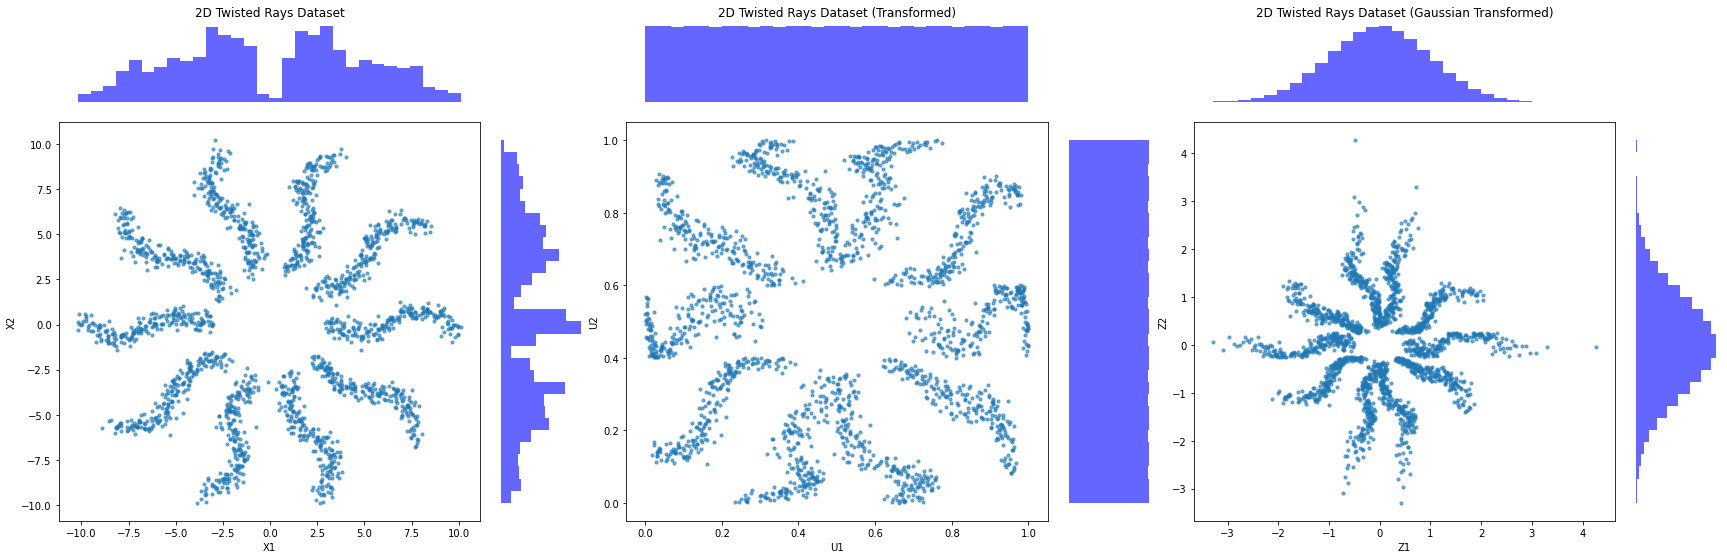

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs

def generate_twisted_rays_dataset(n_samples_per_ray=200, n_rays=10, length=10, noise=0.3, twist_factor=0.1, random_state=42):
    np.random.seed(random_state)
    
    data = []
    angles = np.linspace(0, 2 * np.pi, n_rays, endpoint=False)
    
    for angle in angles:
        r = np.linspace(3, length, n_samples_per_ray)
        twist = twist_factor * np.sin(r)  # Add a twist to the rays
        x = r * np.cos(angle + twist) + np.random.normal(0, noise, n_samples_per_ray)
        y = r * np.sin(angle + twist) + np.random.normal(0, noise, n_samples_per_ray)
        data.append(np.vstack((x, y)).T)
    
    data = np.vstack(data)
    return data

def fit_ecdf(data):
    """Fit an empirical CDF to the data."""
    sorted_data = np.sort(data)
    n = len(data)
    ecdf = lambda x: np.searchsorted(sorted_data, x, side='right') / n
    return ecdf

# Generate the dataset
data = generate_twisted_rays_dataset()
data = data[np.random.choice(data.shape[0], data.shape[0], replace=False)]

# Compute the ECDFs and transform the data
cdf1 = fit_ecdf(data[:, 0])
cdf2 = fit_ecdf(data[:, 1])
data_u1 = cdf1(data[:, 0])
data_u2 = cdf2(data[:, 1])
data_u = np.column_stack([data_u1, data_u2])
data_u = np.clip(data_u, 1e-5, 1 - 1e-5)
data_u = data_u[np.random.choice(data_u.shape[0], data_u.shape[0], replace=False)]
data_z = scs.norm.ppf(data_u)
data_z = data_z[np.random.choice(data_z.shape[0], data_z.shape[0], replace=False)]

# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

def add_marginal_histograms(ax, x, y):
    """Add marginal histograms to the scatter plot."""
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
    ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
    
    ax_histx.hist(x, bins=30, color='blue', alpha=0.6)
    ax_histy.hist(y, bins=30, color='blue', alpha=0.6, orientation='horizontal')
    
    ax_histx.axis('off')
    ax_histy.axis('off')

# Plot the original dataset with marginal histograms
axes[0].scatter(data[:, 0], data[:, 1], s=10, alpha=0.6)
add_marginal_histograms(axes[0], data[:, 0], data[:, 1])
axes[0].set_title('2D Twisted Rays Dataset')
axes[0].set_xlabel('X1')
axes[0].set_ylabel('X2')

# Plot the transformed dataset (data_u) with marginal histograms
axes[1].scatter(data_u[:, 0], data_u[:, 1], s=10, alpha=0.6)
add_marginal_histograms(axes[1], data_u[:, 0], data_u[:, 1])
axes[1].set_title('2D Twisted Rays Dataset (Transformed)')
axes[1].set_xlabel('U1')
axes[1].set_ylabel('U2')

# Plot the transformed dataset (data_z) with marginal histograms
axes[2].scatter(data_z[:, 0], data_z[:, 1], s=10, alpha=0.6)
add_marginal_histograms(axes[2], data_z[:, 0], data_z[:, 1])
axes[2].set_title('2D Twisted Rays Dataset (Gaussian Transformed)')
axes[2].set_xlabel('Z1')
axes[2].set_ylabel('Z2')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

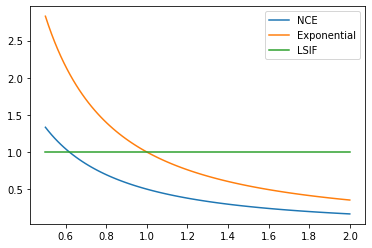

In [ ]:
def loss_nce(r_p, r_q,p_size, q_size):
    '''Weight w(c)=1/(c^2 + c)'''
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 

def loss_exponential(r_p,r_q):
    '''Weight w(c)=1/c^(3/2)'''
    c_p = r_p/(1+r_p)
    c_p = 2*c_p-1
    c_q = r_q/(1+r_q)
    c_q = 2*c_q-1
    return ((-c_p).exp() + c_q.exp()).mean()

def loss_LSIF(r_p, r_q):
    '''Weight w(c)=1'''
    return (-r_p.log() +0.5*r_q.log()**2).mean()


c_vals = np.linspace(0.01, 2, 100)

plt.plot(c_vals, (1/(c_vals**2 + c_vals)), label='NCE')
plt.plot(c_vals, (1/c_vals**(3/2)), label='Exponential')
plt.plot(c_vals, (c_vals**0), label='LSIF')
plt.legend()

C:\Users\david\AppData\Local\Temp\ipykernel_8532\2409954405.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_z = torch.tensor(data_z, dtype=torch.float32)
  0%|          | 0/12500 [00:00<?, ?it/s]C:\Users\david\AppData\Local\Temp\ipykernel_8532\2409954405.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_p = ratio_copula(torch.tensor(data_z).float())
  1%|          | 104/12500 [00:04<06:18, 32.76it/s]

Epoch 100, loss and normalising constant 1.8316187858581543 0.9808299541473389


  2%|▏         | 204/12500 [00:07<11:55, 17.19it/s]

Epoch 200, loss and normalising constant 1.7727514505386353 0.9528101682662964


  2%|▏         | 308/12500 [00:12<07:06, 28.62it/s]

Epoch 300, loss and normalising constant 1.7229970693588257 0.9177383184432983


  3%|▎         | 406/12500 [00:15<06:08, 32.82it/s]

Epoch 400, loss and normalising constant 1.7626911401748657 0.8798770308494568


  4%|▍         | 507/12500 [00:19<07:12, 27.72it/s]

Epoch 500, loss and normalising constant 1.7167916297912598 0.8425750136375427


  5%|▍         | 607/12500 [00:21<05:43, 34.66it/s]

Epoch 600, loss and normalising constant 1.7218904495239258 0.8046283721923828


  6%|▌         | 707/12500 [00:24<05:38, 34.83it/s]

Epoch 700, loss and normalising constant 1.7420635223388672 0.7690696716308594


  6%|▋         | 805/12500 [00:27<06:16, 31.06it/s]

Epoch 800, loss and normalising constant 1.7314058542251587 0.7330847978591919


  7%|▋         | 905/12500 [00:30<05:30, 35.13it/s]

Epoch 900, loss and normalising constant 1.7087842226028442 0.7018559575080872


  8%|▊         | 1005/12500 [00:33<05:58, 32.03it/s]

Epoch 1000, loss and normalising constant 1.730401635169983 0.6714402437210083


  9%|▉         | 1105/12500 [00:36<05:53, 32.24it/s]

Epoch 1100, loss and normalising constant 1.72519850730896 0.6428883075714111


 10%|▉         | 1205/12500 [00:39<05:25, 34.73it/s]

Epoch 1200, loss and normalising constant 1.7129205465316772 0.6144182085990906


 10%|█         | 1305/12500 [00:42<05:37, 33.19it/s]

Epoch 1300, loss and normalising constant 1.7003371715545654 0.5875869989395142


 11%|█         | 1405/12500 [00:45<05:12, 35.46it/s]

Epoch 1400, loss and normalising constant 1.7036876678466797 0.5609496235847473


 12%|█▏        | 1505/12500 [00:48<05:18, 34.56it/s]

Epoch 1500, loss and normalising constant 1.7273576259613037 0.5391532182693481


 13%|█▎        | 1605/12500 [00:51<05:11, 34.97it/s]

Epoch 1600, loss and normalising constant 1.7151347398757935 0.5119366645812988


 14%|█▎        | 1705/12500 [00:54<05:26, 33.07it/s]

Epoch 1700, loss and normalising constant 1.706803321838379 0.48890870809555054


 14%|█▍        | 1805/12500 [00:57<05:18, 33.54it/s]

Epoch 1800, loss and normalising constant 1.7323601245880127 0.46785950660705566


 15%|█▌        | 1903/12500 [01:00<06:10, 28.60it/s]

Epoch 1900, loss and normalising constant 1.6988800764083862 0.4510720372200012


 16%|█▌        | 2007/12500 [01:03<06:13, 28.08it/s]

Epoch 2000, loss and normalising constant 1.7201389074325562 0.4307740032672882


 17%|█▋        | 2107/12500 [01:06<05:06, 33.94it/s]

Epoch 2100, loss and normalising constant 1.733901858329773 0.4142046570777893


 18%|█▊        | 2207/12500 [01:09<05:16, 32.53it/s]

Epoch 2200, loss and normalising constant 1.7210420370101929 0.3994999825954437


 18%|█▊        | 2307/12500 [01:13<05:12, 32.65it/s]

Epoch 2300, loss and normalising constant 1.7253096103668213 0.38628047704696655


 19%|█▉        | 2407/12500 [01:16<05:09, 32.64it/s]

Epoch 2400, loss and normalising constant 1.7085438966751099 0.373811811208725


 20%|██        | 2507/12500 [01:19<05:24, 30.79it/s]

Epoch 2500, loss and normalising constant 1.7297248840332031 0.3645867705345154


 21%|██        | 2603/12500 [01:22<05:05, 32.37it/s]

Epoch 2600, loss and normalising constant 1.7017956972122192 0.35572636127471924


 22%|██▏       | 2707/12500 [01:25<04:50, 33.68it/s]

Epoch 2700, loss and normalising constant 1.7581899166107178 0.34247565269470215


 22%|██▏       | 2803/12500 [01:28<05:22, 30.09it/s]

Epoch 2800, loss and normalising constant 1.7348154783248901 0.33715006709098816


 23%|██▎       | 2906/12500 [01:31<04:45, 33.63it/s]

Epoch 2900, loss and normalising constant 1.7023242712020874 0.32885780930519104


 24%|██▍       | 3006/12500 [01:34<04:52, 32.47it/s]

Epoch 3000, loss and normalising constant 1.7301186323165894 0.3214135766029358


 25%|██▍       | 3106/12500 [01:37<04:43, 33.15it/s]

Epoch 3100, loss and normalising constant 1.7370723485946655 0.31476062536239624


 26%|██▌       | 3206/12500 [01:40<04:37, 33.47it/s]

Epoch 3200, loss and normalising constant 1.7279765605926514 0.30725711584091187


 26%|██▋       | 3306/12500 [01:44<04:31, 33.92it/s]

Epoch 3300, loss and normalising constant 1.7355213165283203 0.29910069704055786


 27%|██▋       | 3406/12500 [01:47<04:33, 33.21it/s]

Epoch 3400, loss and normalising constant 1.7765190601348877 0.29464301466941833


 28%|██▊       | 3506/12500 [01:50<04:30, 33.24it/s]

Epoch 3500, loss and normalising constant 1.740334391593933 0.29062801599502563


 29%|██▉       | 3606/12500 [01:53<04:33, 32.58it/s]

Epoch 3600, loss and normalising constant 1.73654043674469 0.2843872606754303


 30%|██▉       | 3706/12500 [01:57<05:33, 26.40it/s]

Epoch 3700, loss and normalising constant 1.766448736190796 0.28709515929222107


 30%|███       | 3806/12500 [02:00<04:46, 30.29it/s]

Epoch 3800, loss and normalising constant 1.8347686529159546 0.28831297159194946


 31%|███       | 3905/12500 [02:04<04:58, 28.75it/s]

Epoch 3900, loss and normalising constant 1.7760080099105835 0.28754693269729614


 32%|███▏      | 4000/12500 [02:07<05:21, 26.40it/s]

Epoch 4000, loss and normalising constant 1.7327226400375366 0.28465035557746887


 33%|███▎      | 4105/12500 [02:11<04:35, 30.43it/s]

Epoch 4100, loss and normalising constant 1.7210999727249146 0.27872708439826965


 34%|███▎      | 4203/12500 [02:14<04:34, 30.28it/s]

Epoch 4200, loss and normalising constant 1.7124342918395996 0.26923948526382446


 34%|███▍      | 4307/12500 [02:18<04:25, 30.80it/s]

Epoch 4300, loss and normalising constant 1.7196955680847168 0.2681403160095215


 35%|███▌      | 4405/12500 [02:21<04:23, 30.74it/s]

Epoch 4400, loss and normalising constant 1.7402952909469604 0.26546186208724976


 36%|███▌      | 4504/12500 [02:25<04:17, 31.10it/s]

Epoch 4500, loss and normalising constant 1.7389875650405884 0.26308825612068176


 37%|███▋      | 4604/12500 [02:28<04:15, 30.90it/s]

Epoch 4600, loss and normalising constant 1.7332438230514526 0.25914162397384644


 38%|███▊      | 4704/12500 [02:31<04:27, 29.11it/s]

Epoch 4700, loss and normalising constant 1.7319267988204956 0.25657933950424194


 38%|███▊      | 4805/12500 [02:35<04:14, 30.24it/s]

Epoch 4800, loss and normalising constant 1.7446184158325195 0.2550729215145111


 39%|███▉      | 4903/12500 [02:38<04:14, 29.86it/s]

Epoch 4900, loss and normalising constant 1.7239348888397217 0.2529808282852173


 40%|████      | 5004/12500 [02:42<04:03, 30.77it/s]

Epoch 5000, loss and normalising constant 1.7155330181121826 0.25071626901626587


 41%|████      | 5103/12500 [02:45<04:06, 29.98it/s]

Epoch 5100, loss and normalising constant 1.725540280342102 0.24922755360603333


 42%|████▏     | 5204/12500 [02:49<04:01, 30.24it/s]

Epoch 5200, loss and normalising constant 1.7169620990753174 0.2469387650489807


 42%|████▏     | 5303/12500 [02:52<03:51, 31.11it/s]

Epoch 5300, loss and normalising constant 1.7302765846252441 0.24395643174648285


 43%|████▎     | 5404/12500 [02:56<04:03, 29.09it/s]

Epoch 5400, loss and normalising constant 1.731036901473999 0.24331852793693542


 44%|████▍     | 5504/12500 [02:59<03:50, 30.38it/s]

Epoch 5500, loss and normalising constant 1.734092354774475 0.24126863479614258


 45%|████▍     | 5606/12500 [03:03<03:50, 29.85it/s]

Epoch 5600, loss and normalising constant 1.7422667741775513 0.2410680502653122


 46%|████▌     | 5703/12500 [03:06<03:56, 28.68it/s]

Epoch 5700, loss and normalising constant 1.7233210802078247 0.24010352790355682


 46%|████▋     | 5804/12500 [03:09<03:43, 29.92it/s]

Epoch 5800, loss and normalising constant 1.7256208658218384 0.23836249113082886


 47%|████▋     | 5903/12500 [03:13<03:38, 30.20it/s]

Epoch 5900, loss and normalising constant 1.73119056224823 0.2362588793039322


 48%|████▊     | 6005/12500 [03:16<03:40, 29.44it/s]

Epoch 6000, loss and normalising constant 1.7214661836624146 0.2360338717699051


 49%|████▉     | 6106/12500 [03:20<03:29, 30.51it/s]

Epoch 6100, loss and normalising constant 1.7581290006637573 0.23393094539642334


 50%|████▉     | 6204/12500 [03:23<03:26, 30.44it/s]

Epoch 6200, loss and normalising constant 1.7026313543319702 0.23419776558876038


 50%|█████     | 6307/12500 [03:27<03:24, 30.26it/s]

Epoch 6300, loss and normalising constant 1.7380497455596924 0.23222026228904724


 51%|█████     | 6405/12500 [03:30<03:24, 29.79it/s]

Epoch 6400, loss and normalising constant 1.797713041305542 0.23105362057685852


 52%|█████▏    | 6505/12500 [03:34<03:27, 28.91it/s]

Epoch 6500, loss and normalising constant 1.71881902217865 0.22982293367385864


 53%|█████▎    | 6606/12500 [03:37<03:24, 28.88it/s]

Epoch 6600, loss and normalising constant 1.762643575668335 0.22977665066719055


 54%|█████▎    | 6706/12500 [03:41<03:24, 28.33it/s]

Epoch 6700, loss and normalising constant 1.7400096654891968 0.22886765003204346


 54%|█████▍    | 6806/12500 [03:44<03:03, 31.11it/s]

Epoch 6800, loss and normalising constant 1.7365727424621582 0.2277529239654541


 55%|█████▌    | 6904/12500 [03:48<03:11, 29.30it/s]

Epoch 6900, loss and normalising constant 1.7373257875442505 0.2265547513961792


 56%|█████▌    | 7007/12500 [03:51<03:07, 29.30it/s]

Epoch 7000, loss and normalising constant 1.7727266550064087 0.22495339810848236


 57%|█████▋    | 7105/12500 [03:55<02:57, 30.43it/s]

Epoch 7100, loss and normalising constant 1.720887541770935 0.22656841576099396


 58%|█████▊    | 7201/12500 [03:58<02:56, 30.03it/s]

Epoch 7200, loss and normalising constant 1.7222139835357666 0.22370116412639618


 58%|█████▊    | 7304/12500 [04:01<03:09, 27.47it/s]

Epoch 7300, loss and normalising constant 1.7391488552093506 0.2246253341436386


 59%|█████▉    | 7405/12500 [04:05<02:59, 28.41it/s]

Epoch 7400, loss and normalising constant 1.7510008811950684 0.21994063258171082


 60%|██████    | 7506/12500 [04:08<02:45, 30.09it/s]

Epoch 7500, loss and normalising constant 1.7189067602157593 0.22030963003635406


 61%|██████    | 7606/12500 [04:12<02:41, 30.31it/s]

Epoch 7600, loss and normalising constant 1.7387149333953857 0.21802634000778198


 62%|██████▏   | 7704/12500 [04:15<02:39, 30.11it/s]

Epoch 7700, loss and normalising constant 1.7262542247772217 0.2183770388364792


 62%|██████▏   | 7806/12500 [04:19<02:38, 29.62it/s]

Epoch 7800, loss and normalising constant 1.714673638343811 0.21860316395759583


 63%|██████▎   | 7903/12500 [04:22<02:53, 26.52it/s]

Epoch 7900, loss and normalising constant 1.7529431581497192 0.21698452532291412


 64%|██████▍   | 8004/12500 [04:25<02:27, 30.57it/s]

Epoch 8000, loss and normalising constant 1.7271628379821777 0.21620915830135345


 65%|██████▍   | 8105/12500 [04:29<02:33, 28.57it/s]

Epoch 8100, loss and normalising constant 1.7484397888183594 0.2157251536846161


 66%|██████▌   | 8205/12500 [04:32<02:37, 27.27it/s]

Epoch 8200, loss and normalising constant 1.7267898321151733 0.21711209416389465


 66%|██████▋   | 8304/12500 [04:36<02:17, 30.52it/s]

Epoch 8300, loss and normalising constant 1.7350374460220337 0.21619710326194763


 67%|██████▋   | 8406/12500 [04:39<02:15, 30.20it/s]

Epoch 8400, loss and normalising constant 1.700031042098999 0.21379125118255615


 68%|██████▊   | 8507/12500 [04:43<02:08, 31.07it/s]

Epoch 8500, loss and normalising constant 1.7042121887207031 0.21388892829418182


 69%|██████▉   | 8607/12500 [04:46<02:05, 30.95it/s]

Epoch 8600, loss and normalising constant 1.7314043045043945 0.21367020905017853


 70%|██████▉   | 8704/12500 [04:49<02:01, 31.29it/s]

Epoch 8700, loss and normalising constant 1.7346737384796143 0.21314719319343567


 70%|███████   | 8807/12500 [04:53<02:02, 30.10it/s]

Epoch 8800, loss and normalising constant 1.7397048473358154 0.21531270444393158


 71%|███████   | 8906/12500 [04:56<01:55, 31.19it/s]

Epoch 8900, loss and normalising constant 1.7202174663543701 0.21417118608951569


 72%|███████▏  | 9004/12500 [04:59<02:01, 28.85it/s]

Epoch 9000, loss and normalising constant 1.7369444370269775 0.21408265829086304


 73%|███████▎  | 9104/12500 [05:03<02:05, 26.96it/s]

Epoch 9100, loss and normalising constant 1.7325090169906616 0.21352380514144897


 74%|███████▎  | 9204/12500 [05:06<01:47, 30.66it/s]

Epoch 9200, loss and normalising constant 1.710105061531067 0.21272510290145874


 74%|███████▍  | 9305/12500 [05:09<01:44, 30.62it/s]

Epoch 9300, loss and normalising constant 1.722957730293274 0.21173615753650665


 75%|███████▌  | 9405/12500 [05:13<01:40, 30.86it/s]

Epoch 9400, loss and normalising constant 1.7376362085342407 0.21150551736354828


 76%|███████▌  | 9505/12500 [05:16<01:37, 30.78it/s]

Epoch 9500, loss and normalising constant 1.7250772714614868 0.210112065076828


 77%|███████▋  | 9604/12500 [05:20<01:34, 30.60it/s]

Epoch 9600, loss and normalising constant 1.796265959739685 0.21020115911960602


 78%|███████▊  | 9707/12500 [05:23<01:37, 28.57it/s]

Epoch 9700, loss and normalising constant 1.7193540334701538 0.2075914591550827


 78%|███████▊  | 9806/12500 [05:26<01:27, 30.96it/s]

Epoch 9800, loss and normalising constant 1.7251989841461182 0.20821329951286316


 79%|███████▉  | 9907/12500 [05:30<01:24, 30.52it/s]

Epoch 9900, loss and normalising constant 1.7657971382141113 0.21030233800411224


 80%|████████  | 10005/12500 [05:33<01:26, 28.87it/s]

Epoch 10000, loss and normalising constant 1.7768902778625488 0.2120518684387207


 81%|████████  | 10105/12500 [05:37<01:17, 31.06it/s]

Epoch 10100, loss and normalising constant 1.7685778141021729 0.21557743847370148


 82%|████████▏ | 10204/12500 [05:40<01:23, 27.36it/s]

Epoch 10200, loss and normalising constant 1.756311297416687 0.21770864725112915


 82%|████████▏ | 10304/12500 [05:43<01:13, 29.84it/s]

Epoch 10300, loss and normalising constant 1.787440299987793 0.21754124760627747


 83%|████████▎ | 10404/12500 [05:47<01:09, 30.29it/s]

Epoch 10400, loss and normalising constant 1.799043893814087 0.21899406611919403


 84%|████████▍ | 10506/12500 [05:50<01:04, 30.82it/s]

Epoch 10500, loss and normalising constant 1.7544231414794922 0.2205490618944168


 85%|████████▍ | 10604/12500 [05:54<01:02, 30.18it/s]

Epoch 10600, loss and normalising constant 1.7817795276641846 0.21905390918254852


 86%|████████▌ | 10704/12500 [05:57<01:03, 28.49it/s]

Epoch 10700, loss and normalising constant 1.7902618646621704 0.21923552453517914


 86%|████████▋ | 10804/12500 [06:01<00:55, 30.78it/s]

Epoch 10800, loss and normalising constant 1.7325173616409302 0.2201913446187973


 87%|████████▋ | 10905/12500 [06:04<01:00, 26.58it/s]

Epoch 10900, loss and normalising constant 1.735204815864563 0.21567463874816895


 88%|████████▊ | 11007/12500 [06:08<00:49, 30.29it/s]

Epoch 11000, loss and normalising constant 1.7368085384368896 0.21364234387874603


 89%|████████▉ | 11103/12500 [06:11<01:03, 22.00it/s]

Epoch 11100, loss and normalising constant 1.7247785329818726 0.21097968518733978


 90%|████████▉ | 11205/12500 [06:15<00:42, 30.40it/s]

Epoch 11200, loss and normalising constant 1.7170915603637695 0.20833073556423187


 90%|█████████ | 11304/12500 [06:18<00:39, 30.60it/s]

Epoch 11300, loss and normalising constant 1.7302242517471313 0.20441679656505585


 91%|█████████ | 11406/12500 [06:22<00:42, 26.03it/s]

Epoch 11400, loss and normalising constant 1.7098675966262817 0.20530053973197937


 92%|█████████▏| 11505/12500 [06:26<00:38, 26.11it/s]

Epoch 11500, loss and normalising constant 1.70171320438385 0.20417404174804688


 93%|█████████▎| 11604/12500 [06:30<00:34, 25.62it/s]

Epoch 11600, loss and normalising constant 1.871462345123291 0.19880911707878113


 94%|█████████▎| 11707/12500 [06:34<00:26, 30.08it/s]

Epoch 11700, loss and normalising constant 1.7180355787277222 0.20598502457141876


 94%|█████████▍| 11803/12500 [06:38<00:25, 27.14it/s]

Epoch 11800, loss and normalising constant 1.7241665124893188 0.20067951083183289


 95%|█████████▌| 11906/12500 [06:41<00:20, 28.64it/s]

Epoch 11900, loss and normalising constant 1.717397928237915 0.20027197897434235


 96%|█████████▌| 12006/12500 [06:44<00:16, 30.08it/s]

Epoch 12000, loss and normalising constant 1.725441575050354 0.1993967890739441


 97%|█████████▋| 12106/12500 [06:48<00:13, 29.85it/s]

Epoch 12100, loss and normalising constant 1.7331665754318237 0.1966528445482254


 98%|█████████▊| 12205/12500 [06:51<00:10, 29.35it/s]

Epoch 12200, loss and normalising constant 1.742003321647644 0.1967819482088089


 98%|█████████▊| 12306/12500 [06:55<00:06, 30.61it/s]

Epoch 12300, loss and normalising constant 1.8123058080673218 0.1927180141210556


 99%|█████████▉| 12404/12500 [06:58<00:03, 29.38it/s]

Epoch 12400, loss and normalising constant 1.758603572845459 0.19464226067066193


100%|██████████| 12500/12500 [07:02<00:00, 29.61it/s]


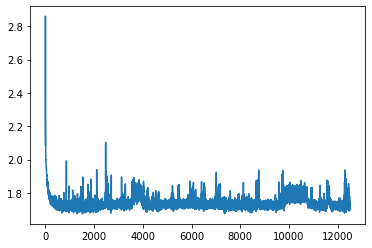

In [13]:
ratio_copula = Ratio(h_dim=100, in_dim=2, h_layers=5, normalising_cst = True, c = 1.0)
data_z = torch.tensor(data_z, dtype=torch.float32)

loss_hist = []
max_grad_norm = 0.01 

optimizer = torch.optim.Adam(ratio_copula.parameters(), lr=0.003, weight_decay=0.00005)
for epoch in tqdm(range(12500)):
    optimizer.zero_grad()
    r_p = ratio_copula(torch.tensor(data_z).float())
    r_q = ratio_copula(torch.tensor(scs.norm.rvs(size=(data_z.shape[0],data_z.shape[1]))).float())
    #loss = loss_nce(r_p, r_q, data_z.shape[0], data_z.shape[0]) #lr=0.003, weight_decay=0.00005 12500iter
    loss = loss_exponential(r_p, r_q) #lr=0.003, weight_decay=0.00005 12500iter
    #loss = loss_LSIF(r_p, r_q) # lr=0.00003, weight_decay=0.00005 12500iter
    loss.backward()
    torch.nn.utils.clip_grad_norm_(ratio_copula.parameters(), max_grad_norm)
    loss_hist.append(loss.item())
    optimizer.step()
    if epoch % 100 == 0 and epoch > 0:
        with torch.no_grad():
             print(f'Epoch {epoch}, loss and normalising constant {loss.item()}', ratio_copula.c.item())
plt.plot(loss_hist)

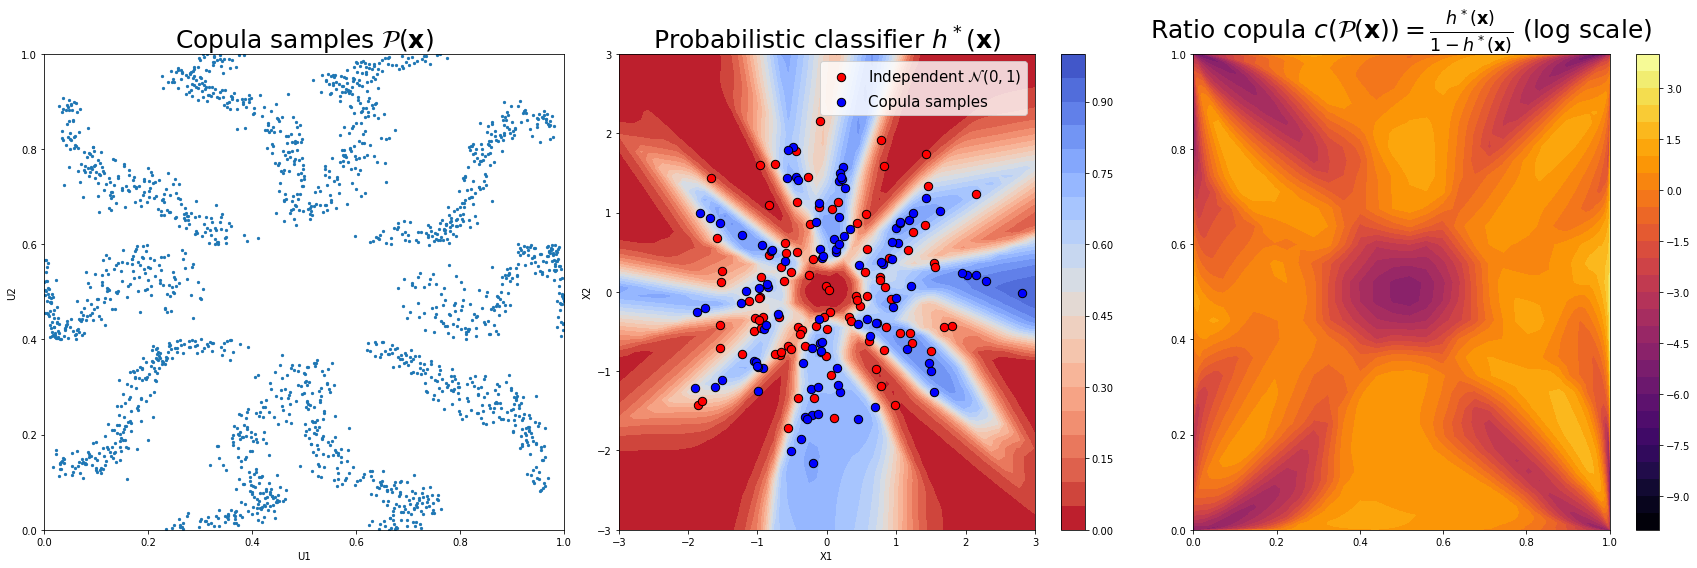

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.stats as scs

# Set font size
font_size = 25

# Assuming ratio_copula is already trained
# Create a grid for plotting
x, y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
z = torch.tensor(np.column_stack((x.flatten(), y.flatten())))
gauss = scs.norm.pdf(x) * scs.norm.pdf(y)

# Get the ratio
r = ratio_copula(z.float()).detach().numpy()
Z = np.log(r.reshape(100, 100))
#Z_gauss = Z + np.log(gauss)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8), gridspec_kw={'width_ratios': [1, 1, 1]})

# First subplot: scatter plot of data_u
axes[0].scatter(data_u[:5000, 0], data_u[:5000, 1], s=5)
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)
axes[0].set_title(r'Copula samples $\mathcal{P}(\mathbf{x})$', fontsize=font_size)
axes[0].set_xlabel('U1')
axes[0].set_ylabel('U2')

# Second subplot: contour plot of r/(1+r) with scatter plots of data_gaussian[:100] and data_z[:100]
r_transformed = r / (1 + r)
Z_classifier = r_transformed.reshape(100, 100)

contour = axes[1].contourf(x, y, Z_classifier, levels=20, cmap='coolwarm_r')
axes[1].scatter(torch.randn(100, 2)[:, 0], torch.randn(100, 2)[:, 1], color='red', edgecolors="k", s=70, label=r'Independent $\mathcal{N}(0,1)$', marker='o')
axes[1].scatter(data_z[:100, 0], data_z[:100, 1], color='blue', s=70, label='Copula samples', edgecolors="k", marker='o')
axes[1].set_xlim(-3, 3)
axes[1].set_ylim(-3, 3)
axes[1].set_title(r'Probabilistic classifier $h^*(\mathbf{x})$', fontsize=font_size)
axes[1].legend(fontsize=15)
fig.colorbar(contour, ax=axes[1])
axes[1].set_xlabel('X1')
axes[1].set_ylabel('X2')

# Third subplot: ratio model
contour = axes[2].contourf(scs.norm.cdf(x), scs.norm.cdf(y), Z.reshape(100, 100), levels=30, cmap='inferno')
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 1)
axes[2].set_title(r'Ratio copula $c\left(\mathcal{P}(\mathbf{x})\right)=\frac{h^*(\mathbf{x})}{1-h^*(\mathbf{x})}$ (log scale)', fontsize=font_size)
#axes[2].scatter(data_u[:5000, 0], data_u[:5000, 1], s=5, c='blue')
fig.colorbar(contour, ax=axes[2])

plt.tight_layout()  
plt.show()

In [408]:
# save the grids after training by uncommenting

#Z_exp_loss = Z_gauss
#Z_nce_loss = Z_gauss
#Z_LSIF_loss = Z_gauss

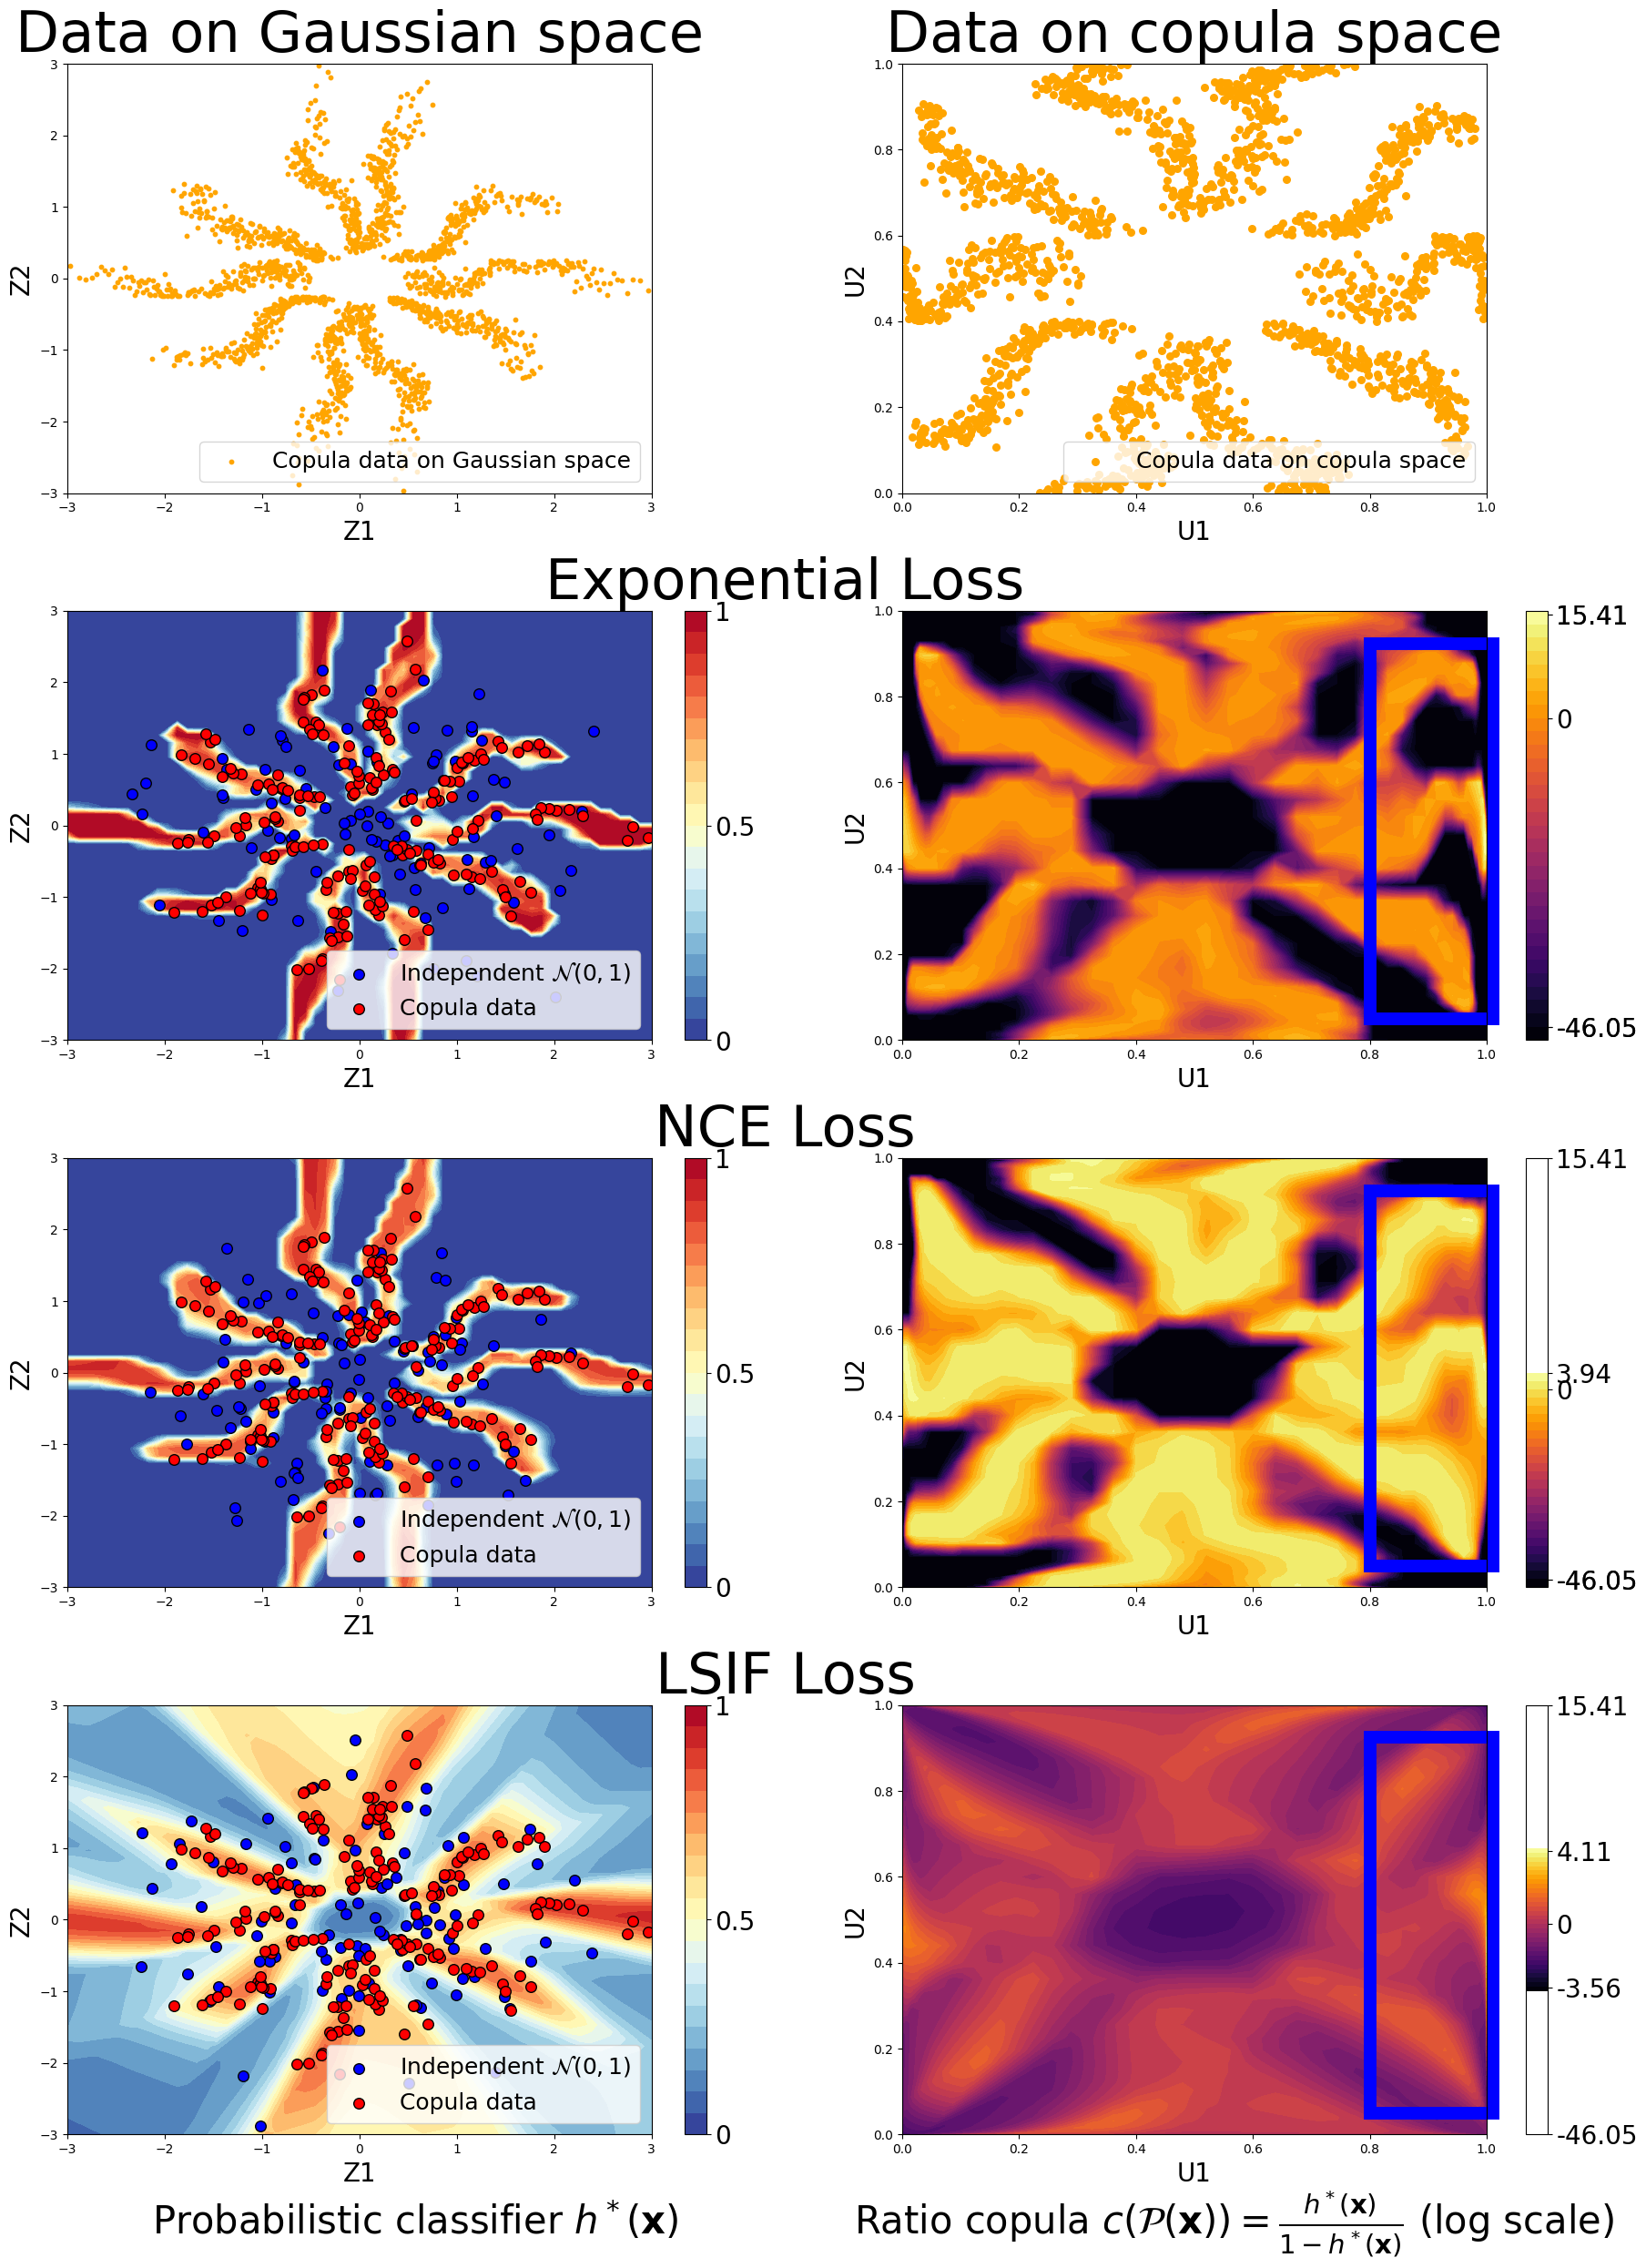

In [146]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.stats as scs
import matplotlib.patches as patches

# Set font size
font_size = 23
u_v_size = 20
# Create a grid for plotting
x, y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))

# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(18, 24), gridspec_kw={'width_ratios': [1, 1]},constrained_layout=True)

# Define the data for each row
data_list = [
    (Z_exp_loss, 'Exponential Loss'),
    (Z_nce_loss, 'NCE Loss'),
    (Z_LSIF_loss, 'LSIF Loss')
]
v_min = min([Z.min() for Z, _ in data_list])
v_max = max([Z.max() for Z, _ in data_list])


# First row: scatter plots of samples on copula space and Gaussian space
axes[0, 1].set_title('Data on copula space', fontsize=45, ha='center')
axes[0, 1].scatter(data_u[:, 0], data_u[:, 1], s=30, c='orange', label='Copula data on copula space')
axes[0, 1].set_xlim(0, 1)
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_xlabel('U1', fontsize = u_v_size)
axes[0, 1].set_ylabel('U2', fontsize = u_v_size)
axes[0, 1].legend(fontsize=18, loc='lower right')

axes[0, 0].set_title('Data on Gaussian space', fontsize=45, ha='center')
axes[0, 0].scatter(data_z[:, 0], data_z[:, 1], s=10, c='orange', label='Copula data on Gaussian space')
axes[0, 0].set_xlim(-3, 3)
axes[0, 0].set_ylim(-3, 3)
axes[0, 0].set_xlabel('Z1', fontsize = u_v_size)
axes[0, 0].set_ylabel('Z2', fontsize = u_v_size)
axes[0, 0].legend(fontsize=18, loc='lower right')


for i, (Z_loss, title) in enumerate(data_list):
    # Second subplot: contour plot of r/(1+r) with scatter plots of data_gaussian[:100] and data_z[:100]
    r_transformed = np.exp(Z_loss) / (1 + np.exp(Z_loss))
    contour = axes[i+1, 0].contourf(x, y, r_transformed, levels=20, cmap='RdYlBu_r')
    axes[i+1, 0].scatter(torch.randn(100, 2)[:, 0], torch.randn(100, 2)[:, 1], color='blue', edgecolors="k", s=70, label=r'Independent $\mathcal{N}(0,1)$', marker='o')
    axes[i+1, 0].scatter(data_z[:200, 0], data_z[:200, 1], color='red', s=70, label='Copula data', edgecolors="k", marker='o')
    axes[i+1, 0].set_xlim(-3, 3)
    axes[i+1, 0].set_ylim(-3, 3)
    axes[i+1, 0].legend(fontsize=18, loc='lower right')
    cbar = fig.colorbar(contour, ax=axes[i+1, 0])
    cbar.ax.tick_params(labelsize=ticks_size)
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels(['0', '0.5', '1'])
    axes[i+1, 0].set_xlabel('Z1', fontsize = u_v_size)
    axes[i+1, 0].set_ylabel('Z2', fontsize = u_v_size)

    # Third subplot: ratio model
    contour = axes[i+1, 1].contourf(scs.norm.cdf(x), scs.norm.cdf(y), Z_loss.reshape(100, 100), levels=30, cmap='inferno')
    cbar = fig.colorbar(contour, ax=axes[i+1, 1])
    cbar.ax.tick_params(labelsize=ticks_size)
    if i==2:
        cbar.set_ticks([v_min,Z_loss.min(), 0, Z_loss.max(),v_max])
        cbar.set_ticklabels([f'{v_min:.2f}', f'{Z_loss.min():.2f}', '0', f'{Z_loss.max():.2f}', f'{v_max:.2f}'])
    else:
        cbar.set_ticks([v_min,Z_loss.min(), 0, Z_loss.max(),v_max])
        cbar.set_ticklabels([f'{v_min:.2f}', f'{Z_loss.min():.2f}', '0', f'{Z_loss.max():.2f}', f'{v_max:.2f}'])
    
    
    axes[i+1, 1].set_xlim(0, 1)
    axes[i+1, 1].set_ylim(0, 1)
    axes[i+1, 1].set_title(title, fontsize=45, x=-0.2)
    axes[i+1, 1].set_xlabel('U1', fontsize = u_v_size)
    axes[i+1, 1].set_ylabel('U2', fontsize = u_v_size)

    rect = patches.Rectangle((0.8, 0.05), 0.211, 0.874, linewidth=10, edgecolor='blue', facecolor='none', transform=axes[i + 1, 1].transData, clip_on=False)
    axes[i + 1, 1].add_patch(rect)



fig.text(0.25, -0.02, r'Probabilistic classifier $h^*(\mathbf{x})$', fontsize=30, ha='center')
fig.text(0.75, -0.02, r'Ratio copula $c\left(\mathcal{P}(\mathbf{x})\right)=\frac{h^*(\mathbf{x})}{1-h^*(\mathbf{x})}$ (log scale)', fontsize=30, ha='center')

#plt.tight_layout()
plt.show()